In [1]:
!pip install pandas pandas-ta

In [2]:
import pandas as pd
import pandas_ta as ta
import numpy as np

In [3]:
history = pd.read_csv('./AMZN.csv')

In [4]:
# Reverse dataframe to sort prices by date, ascending order
history = history.iloc[::-1]
history = history.reset_index(drop=True)

In [5]:
history

,Date,Close,Volume,Open,High,Low
0,08/16/2013,14.2410,48396380,14.3275,14.4165,14.2250
1,08/19/2013,14.2785,49548580,14.2595,14.4780,14.1740
2,08/20/2013,14.3545,31705200,14.2940,14.4758,14.2870
3,08/21/2013,14.2285,36301420,14.2545,14.4250,14.1915
4,08/22/2013,14.4865,28451720,14.2400,14.4935,14.2400
...,...,...,...,...,...,...
2510,08/08/2023,139.9400,51710500,140.6200,140.8400,138.4200
2511,08/09/2023,137.8500,50017350,139.9700,140.3200,137.1000
2512,08/10/2023,138.5600,58928400,139.0750,140.4100,137.4900
2513,08/11/2023,138.4100,42905830,137.4000,139.3300,137.0000


In [6]:
WINDOW_SIZE = 2

# Initial window/preliminary data
df = history.iloc[0:WINDOW_SIZE]

In [7]:
def compute_indicators(df):
    df = df.copy()
    
    def get_sma_indicator(length):
        values = ta.sma(df["Close"], length=length)
        if values is None:
            return -1
        return values.where(np.isfinite, -1)
    
    df.loc[:, "MA20"] = get_sma_indicator(length=20)
    df.loc[:, "MA50"] = get_sma_indicator(length=50)
    df.loc[:, "MA100"] = get_sma_indicator(length=100)
    
    return df

def update_and_recalculate(df, series_index):
    # Get new update to include in frame
    new_data = history.iloc[series_index].copy()

    # Insert row in frame
    df.loc[len(df)] = new_data

    # Compute TA
    return compute_indicators(df)

In [8]:
df = compute_indicators(df)

In [9]:
df

,Date,Close,Volume,Open,High,Low,MA20,MA50,MA100
0,08/16/2013,14.2410,48396380,14.3275,14.4165,14.225,-1,-1,-1
1,08/19/2013,14.2785,49548580,14.2595,14.4780,14.174,-1,-1,-1


In [10]:
window = df.loc[0:1,['Date','Close', 'MA20', 'MA50', 'MA100']].to_numpy()
window

array([['08/16/2013', 14.241, -1, -1, -1],
       ['08/19/2013', 14.2785, -1, -1, -1]], dtype=object)

In [11]:
from bot import Bot, BotTracker

# Start iterating over the history data. simulates that we gather price data from an external provider
# at every new step/iteration, we add the price data into the dataframe df and recompute TAs
# then we move the window 1 day forward and only pass into the bot that window

start_index = 0

t = BotTracker(start_index + WINDOW_SIZE - 1)
b = Bot(money=10000, events_listener=t)
print(f"Initial money: {b.budget()}")

while start_index < len(history)-WINDOW_SIZE+1:
    df = update_and_recalculate(df, start_index+WINDOW_SIZE-1)
    window = df.loc[start_index:start_index+WINDOW_SIZE-1,['Date','Close', 'MA20', 'MA50', 'MA100']].to_numpy()
    
    b.think(window)
    if start_index % 100 == 0:
        print(f"Checkpoint at {start_index}, money: {b.budget()}")
    
    start_index += 1
    t.incr()

print(f"Money at the end: {b.budget()}")
    

Initial money: 10000
Checkpoint at 0, money: 10000
Checkpoint at 100, money: 10000
Checkpoint at 200, money: 10000
Closed position, earned: -6%
Checkpoint at 300, money: 9805.213926901091
Checkpoint at 400, money: 9805.213926901091
Checkpoint at 500, money: 6863.649748830764
Closed position, earned: 26%
Closed position, earned: -8%
Checkpoint at 600, money: 10325.303664589252
Checkpoint at 700, money: 10325.303664589252
Checkpoint at 800, money: 10325.303664589252
Checkpoint at 900, money: 10325.303664589252
Checkpoint at 1000, money: 10325.303664589252
Checkpoint at 1100, money: 10325.303664589252
Checkpoint at 1200, money: 7227.712565212476
Closed position, earned: 19%
Checkpoint at 1300, money: 10921.324839978352
Checkpoint at 1400, money: 10921.324839978352
Closed position, earned: -6%
Checkpoint at 1500, money: 10733.190846464944
Checkpoint at 1600, money: 10733.190846464944
Checkpoint at 1700, money: 7513.233592525461
Closed position, earned: 36%
Checkpoint at 1800, money: 11908.

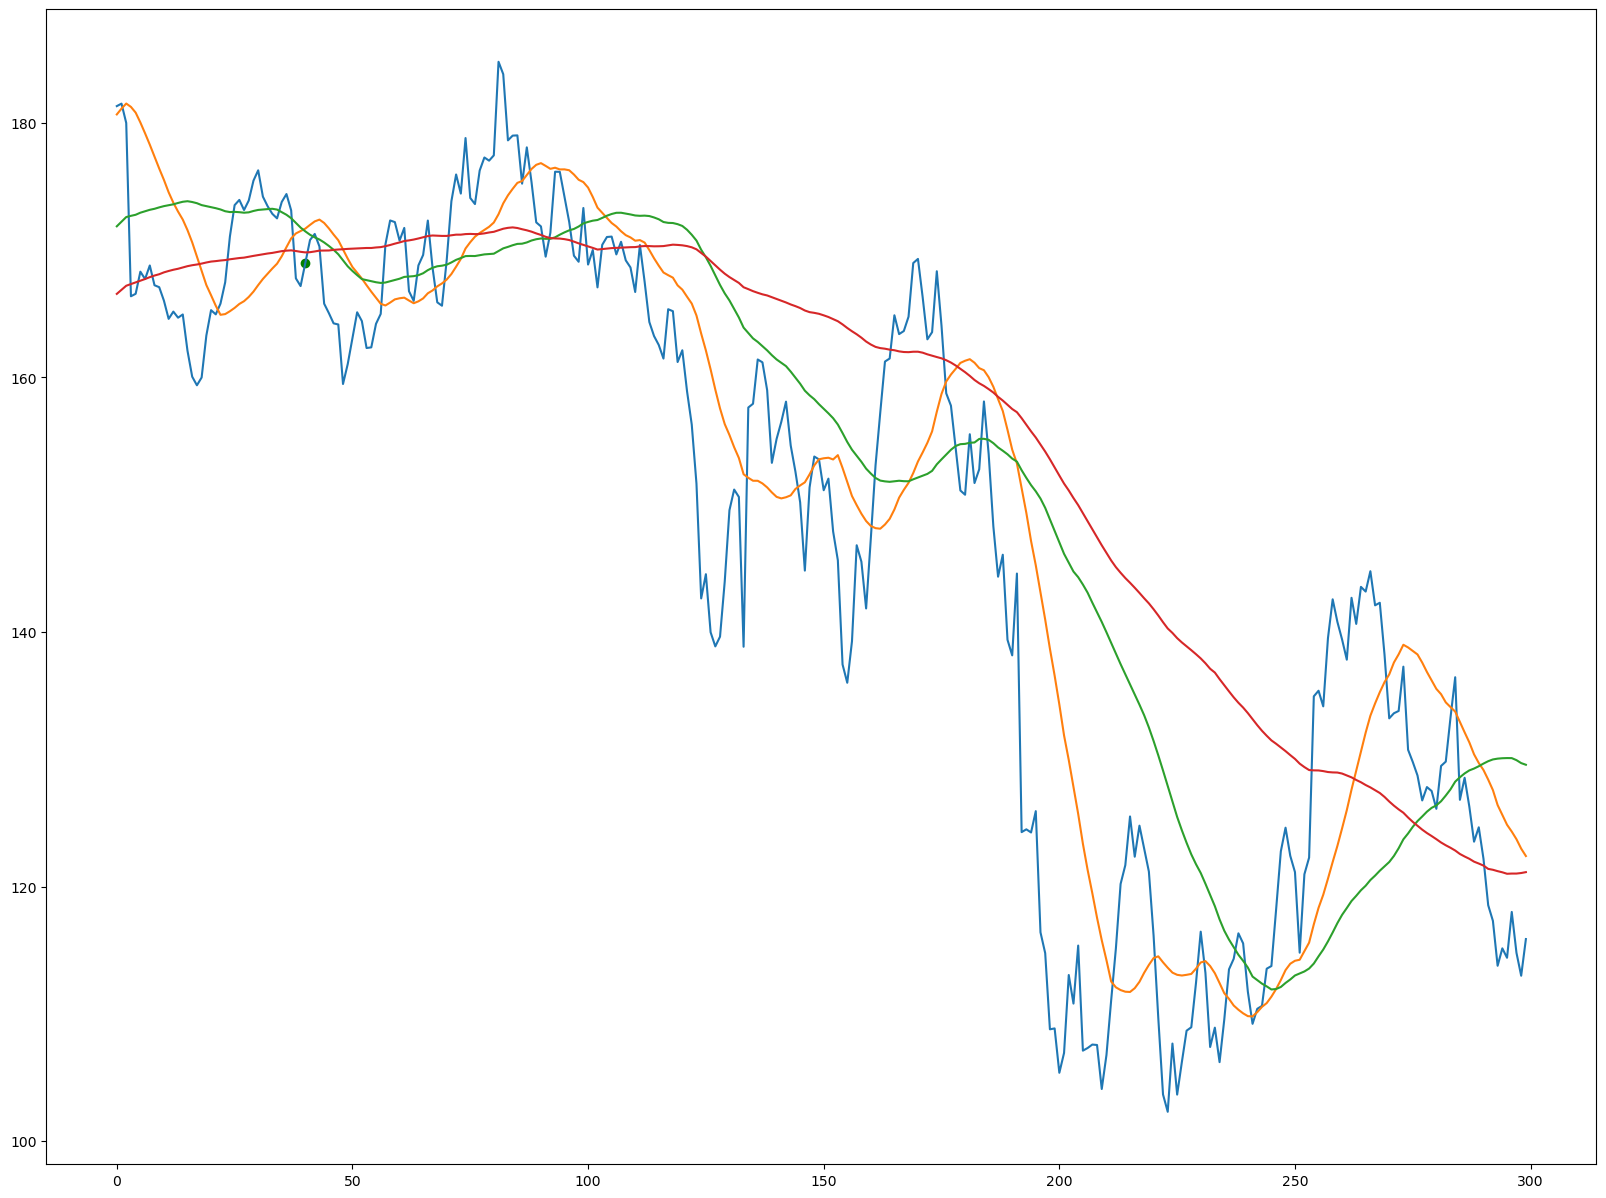

In [28]:
import matplotlib.pyplot as plt

S=2000
E=2300
#tsignals = ta.adx(df['High'], df['Low'], df['Close']).to_numpy()

prices = df['Close'].to_numpy()
ma20 = df['MA20'].to_numpy()
ma50 = df['MA50'].to_numpy()
ma100 = df['MA100'].to_numpy()

plt.figure(figsize=(20, 15))
plt.plot(prices[S:E])
plt.plot(ma20[S:E])
plt.plot(ma50[S:E])
plt.plot(ma100[S:E])
#plt.plot(tsignals[S:E]-100)

opened_positions_data = t.get_for_rendering()
for p in opened_positions_data:
    if p["index"] < S or p["index"] > E:
        continue
    plt.scatter(p["index"]-S, p["price"], color="green")